# U.S. Geological Survey Class GW3099
Advanced Modeling of Groundwater Flow (GW3099)\
Boise, Idaho\
September 16 - 20, 2024

![title](../../images/ClassLocation.jpg)

# GWE Example 1 -- Two dimensional heat transport with thermal bleeding

The "Barends" problem compares GWE model output (temperatures) to the following analytical solution,

$T'(x, z, t) = T_0 + \dfrac{2 \left( T_1 - T_0 \right)}{\sqrt{\pi}} {\displaystyle \int\limits_{\dfrac{x}{2 \sqrt{Dt}}}^{\infty} e^{\displaystyle{ \left( \sigma - \frac{x v}{4 D \sigma} \right)^2}} erfc \Biggl[ \biggl( \dfrac{x^2 h' \sqrt{D'}}{8DH \sigma^2} + \dfrac{z}{2 \sqrt{D'}} \biggr) \biggl( t - \dfrac{x^2}{4D \sigma^2} \biggr)^{-\frac{1}{2}} \Biggr] d\sigma } $

The Barends problem is comprised of two zones, one overlying the other, and explores heat transfer between two lithologic layers. 

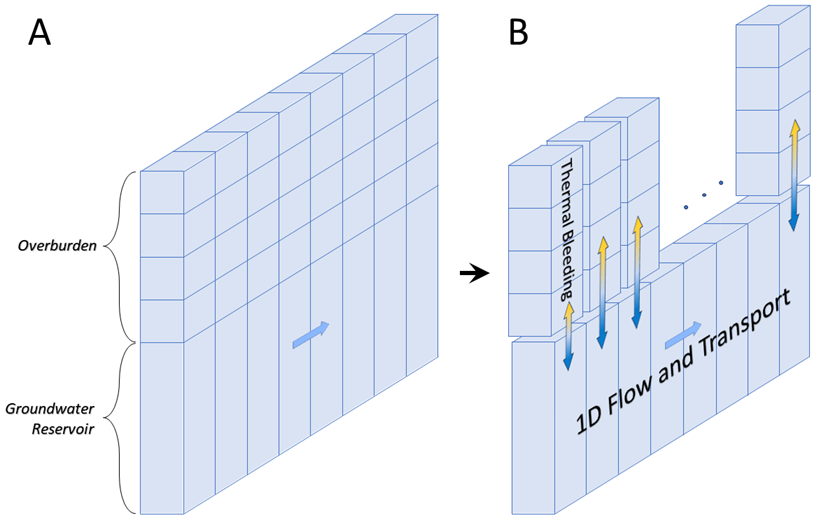

Within the lower layer, groundwater flows from left to right and is hereafter referred to as the groundwater reservoir. The upper layer, hereafter referred to as the overburden, also is saturated; however, there is no groundwater flow and therefore no advective movement of heat within the overburden. The entire model domain is initialized to 80$^{\circ}C$.  At the start of the simulation, the WEL Package injects 30$^{\circ}C$ water into the left-most cell representing the groundwater reservoir. A single 100 $m$ thick layer is used to represent the groundwater reservoir to ensure groundwater flow is 1D.  Groundwater is extracted from the right-most groundwater reservoir cell at the same rate it is injected. Groundwater extracted from the right-most groundwater reservoir cell leaves the model at the simulated temperature of the cell. 


The analytical solution requires that heat transfer within the overburden is in the vertical direction only.  To accomplish this, model cells representing the overburden are only connected to their vertically aligned neighbors. In this way, the model setup has the appearance of being 2-dimensional (2D)(Figure 1A) while effectively restricting heat transfer, whether advective or conductive in nature, to a series of interconnected 1-dimensional (1D) "models" (Figure 1B).  Moreover, each 1D column of cells in the overburden is connected to only one groundwater reservoir cell at its base. Thus, as the temperature in the groundwater reservoir cools as a result of the injected temperature, "thermal bleeding" from the overburden to the groundwater reservoir is induced. Thermal bleeding may have important implications for geothermal systems, such as underground thermal energy storage (UTES) or borehole heat exchanger (BHE) systems.

The DISU grid type supports explicit specification of which cell-to-cell connections to include. By omitting horizontal cell connections within the overburden, both convective and conductive heat exchange among horizontal cell neighbors is effectively turned off.  Equipped with the model setup just described, this notebook may be used to explore the effect of various parameter values on heat transport in a geothermal setting.

In [ ]:
# %matplotlib inline
import math
import os
import warnings

import barends_funcs as barends_sln
import flopy
import gwe_ex1_support_funcs as disu_support
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)

#### Set parameter values used in the model

In [ ]:
# Model units
length_units = "meters"
time_units = "seconds"

# Discretization related parameters
nrow = 1
ncol = 1000  # Number of columns ($-$)
delr = 1.0  # Width along the row ($m$)
delc = 1.0  # Width along the column ($m$)
nlay_res = 1  # Number of layers in the groundwater reservoir ($-$)
nlay_overburden = 100  # Number of layer representing the overburden ($-$)
nlay = nlay_overburden + nlay_res  # Total number of layers ($-$)
top_res = 100.0  # Elevation of the top of the groundwater reservoir ($m$)
H = 100.0  # Reservoir height ($m$)
thk = 1.0  # Unit thickness "into the page" ($m$)
top_overburden = top_res * 2  # top of the model ($m$)
icelltype = 0

# Simulation timing
perlen = 86400.0 * 365  # 1 stress period equals 1 year ($seconds$)
nstp = 1  # Number of time steps per stress period ($-$)
tsmult = 1  # Time step multiplier ($-$)
nper = 300  # Number of simulated stress periods ($-$)
perlen = [perlen] * nper  # Convert to a list
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp, tsmult))

# Aquifer properties
k11 = 9.80670e-7  # Hydraulic conductivity of the groundwater reservoir($m/d$)
k33 = 1e-50  # Vertical hydraulic conductivity of the entire domain ($m/s$)
prsity = 0.25  # Porosity ($-$)
q = 1.2649e-8  # Darcy velocity ($m/s$)

# Heat transport properties/settings
scheme = "TVD"  # Advection solution scheme ($-$)
ktw = 0.6  # Thermal conductivity of the fluid ($\dfrac{W}{m \cdot ^{\circ}C}$)
kts = 0.06667  # Thermal conductivity of the aquifer matrix (which is also the dry overburden material) ($\dfrac{W}{m \cdot ^{\circ}C}$)
rhow = 1000.0  # Density of water ($\frac{kg}{m^3}$) # 3282.296651
cpw = 5000.0  # Mass-based heat capacity of the fluid (($\dfrac{J}{kg \cdot $^{\circ}C}$))
rhos = 2000.0  # Density of the solid material ($\dfrac{kg}{m^3}$)
cps = 500.0  # Mass-based heat capacity of the solid material ($\dfrac{J}{kg \cdot $^{\circ}C}$)
alpha_l = 0.0  # Longitudinal dispersivity ($m$)
ath1 = 1.0e9  # Transverse mechanical dispersivity ($m$)
ath2 = 1.0e9  # Transverse mechanical dispersivity ($m$)
T0 = 80  # Initial temperature of the active domain ($^{\circ}C$)
T1 = 30  # Injected temperature ($^{\circ}C}$)

# Solver parameters
nouter = 50
ninner = 100
hclose = 1e-7
rclose = 1e-6

#### Calculate some values for use in the analytical solution

In [ ]:
# Control the velocity in the groundwater reservoir via the injection rate
Q_well = q * H * thk  # Injection flow rate ($m^3/day$)

# Calculate gw reservoir heat capacity (heat capacity by volume)
rhoCp_bulk = prsity * rhow * cpw + (1 - prsity) * rhos * cps

# Calculate "thermal conduction velocity"
v = q * (rhow * cpw) / rhoCp_bulk

# Calculate bulk thermal conductivity
kt_bulk = prsity * ktw + (1 - prsity) * kts

# Thermal diffusivity
D = kt_bulk / rhoCp_bulk + alpha_l * v

# The overburden thermal diffusion coefficient is the same as for the gw reservoir
# by virtue of how we are setting everything up (same porosity, both are saturated,
# physical properties are the same in both zones)
D_prime = D

# Heat capacity ratio
# (if different rho and Cp values are specified among the overburden and gw
#  reservoir, then this value will need to be calculated based on those values.
h_prime = 1

#### Work-up some values required for the DISU instantiation in FloPy
For the vertical discretization within the overburden, a geometric multiplier is used to refine discretization above the overburden-groundwater reservoir interface

In [ ]:
dismult = 1.0673002615  # Geometric multiplier

# Using one of the support functions from an imported script
Delta_zbot1 = disu_support.dis_mult(top_res, nlay_overburden, dismult)

# Set the thickness of the first layer above the overburden-groundwater reservoir interface
botm_seq = [
    0.01
]  # Starting thickness for the geometric expansion of layer thicknesses

for k in np.arange(1, nlay_overburden):
    botm_seq.append(botm_seq[-1] * dismult)

# Reverse the order for the overburden since botm need to be top -> down
botm_seq_overburden = list(reversed(botm_seq))

# Define botm for overburden
botm_overburden = [top_overburden - botm_seq_overburden[0]]
for thk_interval in botm_seq_overburden[1:]:
    next_elv = botm_overburden[-1] - thk_interval
    botm_overburden.append(next_elv)

botm_overburden = [round(itm, 2) for itm in botm_overburden]

# Continue moving down the profile and determine discretization for the sat zone
if nlay_res == 1:
    botm_res = [0]
else:
    botm_res = [top_res - botm_seq[0]]
    for thk_interval in botm_seq[1:]:
        next_elv = botm_res[-1] - thk_interval
        botm_res.append(next_elv)

    botm_res = [abs(round(itm, 2)) for itm in botm_res]


# Merge the two botm lists for coming up with a single unified botm object
# to pass to the discretization constructor
botm = botm_overburden + botm_res

# Establish a 2D array of the nodal locations
z_tops = [top_overburden] + botm
z_diffs = abs(np.diff(z_tops))
z_mids = z_tops[:-1] - (z_diffs / 2)

# Based on the way the analytical solution works, the interface altitude
# equals 0.  Moreover, the temperature at the interface equals the
# temperature in the 1D groundwater reservoir.  With that in view,
# set the last element to the interface altitude and subtract off the
# elevation of the top of the gw reservoir, which is z-axis point of
# reference
z_mids[-1] = top_res
z_mids = z_mids - 100

x_mids = [j * delr + 0.5 for j in np.arange(ncol)]
X, Y = np.meshgrid(x_mids, z_mids)

#### Setup DISU input

Starting with the VERTICES block input

In [ ]:
iac_lst = []
ja_lst = []
ihc_lst = []
cl12_lst = []
hwva_lst = []
angldeg_lst = []

# VERTICES block input
iv_lst = []
xv_lst = []
yv_lst = []
cell_2d_lst = []
top_lst = []
bot_lst = []

# For top and bottoms, can manually build-out the lists
top_lst = [top_overburden] * ncol
for lay in np.arange(0, nlay - 1):
    top_lst.extend([botm[lay]] * ncol)

bot_lst = []
for lay in np.arange(nlay):
    bot_lst.extend([botm[lay]] * ncol)

topnp = np.array(top_lst)
botnp = np.array(bot_lst)

# Build out VERTICES block (only needs to happen once)
iv, xv_lst, yv_lst, cell_vert_lkup = disu_support.buildout_vertex_locations(
    nlay, ncol, delr
)

vertices = []
for i in np.arange(len(iv)):
    vertices.append([iv[i], xv_lst[i], yv_lst[i]])

Next, the CELL2D block input

In [ ]:
# Cycle through each layer and column.
for lay in np.arange(nlay):
    for col in np.arange(ncol):
        n = lay * ncol + col  # n will be zero based

        # Values for CONNECTIONDATA block
        iac, ja_cell, ihc_cell, cl12_cell, hwva_cell, angldeg_cell = (
            disu_support.get_conndat(
                n, lay, col, nlay, top_overburden, botm, ncol, delr, delc
            )
        )

        # accumulate connection information in lists
        iac_lst.append(iac)
        ja_lst.append(ja_cell)
        ihc_lst.append(ihc_cell)
        cl12_lst.append(cl12_cell)
        hwva_lst.append(hwva_cell)
        angldeg_lst.append(angldeg_cell)

        # Add Cell2D information
        # An example of what cell2d information should look like.
        # [997, 0.09539255, 0.022023124999999998, 4, 997, 1177, 1176, 996],
        # [998, 0.09456585, 0.025338825, 4, 998, 1178, 1177, 997],
        # [999, 0.093623925, 0.028623675, 4, 999, 1179, 1178, 998],
        cell_2d = disu_support.append_cell2d(
            n, xv_lst, yv_lst, cell_vert_lkup, ncol, delr, delc
        )
        cell_2d_lst.append(cell_2d)

iacnp = np.array(iac_lst)
janp = np.array(disu_support.flatten(ja_lst))
ihcnp = np.array(disu_support.flatten(ihc_lst))
cl12np = np.array(disu_support.flatten(cl12_lst))
hwvanp = np.array(disu_support.flatten(hwva_lst))
angldegnp = np.array(disu_support.flatten(angldeg_lst))

#### Establish flow boundary conditions 
To get a uniform flow field, need to establish the WEL flows

In [ ]:
wel_spd_left = []
wel_spd_right = []
res_thickness = top_res - botm_res[-1]
for ly in np.arange(0, nlay_res):
    # calculate the thickness-weighting factor
    if ly < 1:
        thick_interval = top_res - botm_res[ly]
    else:
        thick_interval = botm_res[ly - 1] - botm_res[ly]

    Qcell = Q_well * thick_interval / res_thickness
    id_left = (ly + nlay_overburden) * ncol
    id_right = id_left + (ncol - 1)
    wel_spd_left.append(
        [id_left, Qcell, T1]
    )  # 30.0 is inflow temperature (auxiliary var)
    wel_spd_right.append([id_right, -Qcell])

wel_spd_left = {0: wel_spd_left}
wel_spd_right = {0: wel_spd_right}

#### Establish the function for generating the GWF model

In [ ]:
def build_mf6_flow_model(sim_name, ws):
    print("Building mf6 gwf model...{}".format(sim_name))
    gwf_name = "gwf-" + sim_name
    sim_ws = os.path.join(ws, sim_name, "mf6gwf")

    # Instantiate a MODFLOW 6 simulation
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6"
    )

    # Instantiate time discretization package
    flopy.mf6.ModflowTdis(
        sim,
        nper=1,  # just one steady state stress period for gwf
        perioddata=[(1.0, 1, 1.0)],
        time_units=time_units,
    )

    # Instantiate Iterative model solution package
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )

    # Instantiate a groundwater flow model
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwf_name, save_flows=True)

    # Instantiate an unstructured discretization package
    flopy.mf6.ModflowGwfdisu(
        gwf,
        length_units=length_units,
        nogrb=True,
        nodes=len(topnp),
        nja=len(janp),
        nvert=len(iv),
        top=topnp,
        bot=botnp,
        area=delr * delc,
        idomain=1,
        iac=iacnp,
        ja=janp,
        ihc=ihcnp,
        cl12=cl12np,
        hwva=hwvanp,
        angldegx=angldegnp,
        vertices=vertices,
        cell2d=cell_2d_lst,
        pname="DISU-Barends",
        filename="{}.disu".format(gwf_name),
    )

    # Instantiate node-property flow (NPF) package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_saturation=True,
        save_specific_discharge=True,
        xt3doptions=False,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        pname="NPF-1",
        filename="{}.npf".format(gwf_name),
    )

    # Instantiate initial conditions package for the GWF model
    flopy.mf6.ModflowGwfic(
        gwf,
        strt=top_overburden,
        pname="IC-1",
        filename="{}.ic".format(gwf_name),
    )

    # Instantiating MODFLOW 6 storage package
    # (steady flow conditions, so no actual storage,
    # using to print values in .lst file)
    flopy.mf6.ModflowGwfsto(
        gwf,
        ss=0,
        sy=0,
        steady_state={0: True},
        pname="STO",
        filename="{}.sto".format(gwf_name),
    )

    # Instantiate WEL package for adding water on the left and removing
    # it on the right
    flopy.mf6.ModflowGwfwel(
        gwf,
        auxiliary="TEMPERATURE",
        stress_period_data=wel_spd_left,
        pname="WEL-left",
        filename="{}.wel-left".format(gwf_name),
    )
    # Instantiate WEL package for extracting water on the right
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd_right,
        pname="WEL-right",
        filename="{}.wel-right".format(gwf_name),
    )

    # Instantiating MODFLOW 6 output control package (flow model)
    head_filerecord = "{}.hds".format(sim_name)
    budget_filerecord = "{}.cbc".format(sim_name)
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    return sim

#### Establish the function for generating the GWE model

In [ ]:
def build_mf6_heat_model(sim_name, ws):
    print("Building mf6 gwe model...{}".format(sim_name))
    gwename = "gwe-" + sim_name
    sim_ws = os.path.join(ws, sim_name, "mf6gwe")

    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6"
    )

    # Instantiating MODFLOW 6 groundwater transport model
    gwe = flopy.mf6.MFModel(
        sim,
        model_type="gwe6",
        modelname=gwename,
        model_nam_file="{}.nam".format(gwename),
    )

    # Instantiate Iterative model solution package
    imsgwe = flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        complexity="SIMPLE",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    sim.register_ims_package(imsgwe, [gwe.name])

    # MF6 time discretization differs from corresponding flow simulation
    flopy.mf6.ModflowTdis(
        sim, nper=len(tdis_rc), perioddata=tdis_rc, time_units=time_units
    )

    # Instantiate an unstructured discretization package
    flopy.mf6.ModflowGwedisu(
        gwe,
        length_units=length_units,
        nogrb=True,
        nodes=len(topnp),
        nja=len(janp),
        nvert=len(iv),
        top=topnp,
        bot=botnp,
        area=delr * delc,
        idomain=1,
        iac=iacnp,
        ja=janp,
        ihc=ihcnp,
        cl12=cl12np,
        hwva=hwvanp,
        angldegx=angldegnp,
        vertices=vertices,
        cell2d=cell_2d_lst,
        pname="DISU-Barends",
        filename="{}.disu".format(gwename),
    )

    # Instantiating MODFLOW 6 heat transport initial temperature
    flopy.mf6.ModflowGweic(
        gwe, strt=T0, pname="IC-gwe", filename="{}.ic".format(gwename)
    )

    # Instantiating MODFLOW 6 heat transport advection package
    flopy.mf6.ModflowGweadv(
        gwe, scheme=scheme, pname="ADV", filename="{}.adv".format(gwename)
    )

    # Instantiating MODFLOW 6 heat transport dispersion package
    if ktw != 0:
        flopy.mf6.ModflowGwecnd(
            gwe,
            alh=alpha_l,
            ath1=ath1,
            ath2=ath2,
            ktw=ktw,
            kts=kts,
            pname="CND",
            filename="{}.cnd".format(gwename),
        )

    # Instantiating MODFLOW 6 heat transport mass storage package (consider renaming to est)
    flopy.mf6.ModflowGweest(
        gwe,
        porosity=prsity,
        heat_capacity_solid=cps,
        heat_capacity_water=cpw,
        density_solid=rhos,
        density_water=rhow,
        pname="EST",
        filename="{}.est".format(gwename),
    )

    flopy.mf6.ModflowGwectp(
        gwe,
        save_flows=True,
        maxbound=1,
        stress_period_data={0: [(ncol * nlay_overburden), T1]},
        pname="CTP",
        filename="{}.ctp".format(gwename),
    )

    # Instantiating MODFLOW 6 source/sink mixing package for dealing with
    # auxiliary temperature specified in WEL boundary package.
    sourcerecarray = [("WEL-left", "AUX", "TEMPERATURE")]
    flopy.mf6.ModflowGwessm(
        gwe,
        sources=sourcerecarray,
        pname="SSM",
        filename="{}.ssm".format(gwename),
    )

    # Instantiating MODFLOW 6 heat transport output control package
    # e.g., day 100 = 100 * 86400 = 8,640,000 = 8.64e6
    flopy.mf6.ModflowGweoc(
        gwe,
        budget_filerecord="{}.cbc".format(gwename),
        temperature_filerecord="{}.ucn".format(gwename),
        temperatureprintrecord=[
            ("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")
        ],
        saverecord={
            99: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
            100: [],  # Toggle output off
            199: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
            200: [],  # Toggle output off
            299: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
        },
        # 300: [],  # Toggle output off
        # 399: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
        # 400: [],  # Toggle output off
        # 499: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
        # 500: [],  # Toggle output off
        # 599: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
        # 600: [],  # Toggle output off
        # 699: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
        # 700: [],  # Toggle output off
        # 799: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
        # 800: [],  # Toggle output off
        # 899: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
        # 900: [],  # Toggle output off
        # 999: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],},
        printrecord={99: [("BUDGET", "LAST")]},  # ,
        #             999: [("BUDGET", "LAST")]}
    )

    # Instantiating MODFLOW 6 Flow-Model Interface package
    pd = [
        ("GWFHEAD", "../mf6gwf/" + sim_name + ".hds", None),
        ("GWFBUDGET", "../mf6gwf/" + sim_name + ".cbc", None),
    ]
    flopy.mf6.ModflowGwefmi(gwe, packagedata=pd)

    return sim

#### Build and run the models

In [ ]:
sim_name = "barends"
workspace = os.path.join("temp", "barends")

# Build the GWF model
sim_gwf = build_mf6_flow_model(sim_name, workspace)

# Build the GWE model
sim_gwe = build_mf6_heat_model(sim_name, workspace)

#### A function for writing the input for both models

In [ ]:
def write_mf6_models(sim_gwf, sim_gwe, silent=True):
    # Run the steady-state flow model
    if sim_gwf is not None:
        sim_gwf.write_simulation(silent=silent)

    # Second, run the heat transport model
    if sim_gwe is not None:
        sim_gwe.write_simulation(silent=silent)


write_mf6_models(sim_gwf, sim_gwe, silent=False)

#### Run the simulations containing the GWF and GWE models
The GWF model is run separately from the GWE model because the GWF model is steady-state whereas the GWE model is transient

In [ ]:
def run_model(sim, silent=True):
    # Attempting to run model
    success, buff = sim.run_simulation(silent=silent, report=True)
    if not success:
        print(buff)
    return success


success = run_model(sim_gwf, silent=False)
if success:
    success = run_model(sim_gwe, silent=False)

#### Retrieve simulated temperatures

In [ ]:
gwe = sim_gwe.get_model("gwe-" + sim_name)
sim_temps = gwe.output.temperature().get_alldata()

#### Calculate the analytical solution

In [ ]:
output_times = gwe.output.temperature().get_times()
output_time_labels = [tm / 86400 / 365 for tm in output_times]

answer_back_of_book = barends_sln.calc_analytical_sln(
    [output_times[-1]], X, x_mids, z_mids, T0, T1, D, D_prime, v, H, h_prime
)

#### Plot results
After running once, consider commenting-out the calculation of the analytical solution in order to compare the previous solution to any parameter changes.

In [ ]:
def plot_latest():
    # Get a DIS grid representation of the DISU grid
    sgr = disu_support.gen_faux_grid(
        nrow, ncol, delr, delc, top_overburden, botm
    )

    # Reshape results to fit with DIS results
    dis_temps = []
    temp_arr = sim_temps[
        -1
    ].squeeze()  # Corresponds to first requested output time
    temp_arr = temp_arr.reshape((nlay, nrow, ncol))
    dis_temps.append(temp_arr)
    dis_temps = np.array(dis_temps)

    figsize = (6, 4)
    fontsize = 8

    fig2, ax2 = plt.subplots(figsize=figsize)
    mx2 = flopy.plot.PlotCrossSection(
        ax=ax2, modelgrid=sgr, line={"Row": 0}, extent=(0, 500, 50, 175)
    )
    levels = [32, 40, 50, 60, 70, 75]
    manual_locations = [
        (25, 101),
        (50, 110),
        (85, 118),
        (120, 130),
        (150, 140),
        (175, 145),
    ]

    cb_alt = mx2.contour_array(
        answer_back_of_book[-1], levels=levels, linewidths=1.0, colors="k"
    )
    cb_sim = mx2.contour_array(
        dis_temps[-1, :, 0, :],
        levels=levels,
        linewidths=1.4,
        colors="r",
        linestyles="dashed",
    )
    ax2.tick_params(axis="both", which="major", labelsize=fontsize)
    labels = ax2.clabel(
        cb_sim,
        cb_sim.levels,
        inline=False,
        inline_spacing=0.0,
        fontsize=fontsize,
        fmt="%1d",
        colors="k",
        manual=manual_locations,
    )

    for label in labels:
        label.set_bbox(dict(facecolor="white", pad=2, ec="none"))

    ax2.text(350, 103, "Overburden", fontsize=fontsize)
    ax2.text(350, 87, "Groundwater\nReservoir", fontsize=fontsize)
    ax2.set_xlabel("X coordinate, m", fontsize=fontsize)
    ax2.set_ylabel("Elevation, m", fontsize=fontsize)
    custom_lines = [
        Line2D([0], [0], color="k", lw=1),
        Line2D([0], [0], color="r", lw=1.4, linestyle="dashed"),
    ]

    ax2.legend(
        custom_lines,
        ["Barends Solution", "MODFLOW 6 GWE"],
        loc="upper right",
        frameon=False,
        fontsize=fontsize,
    )

    cb_sim.set_dashes([(0, (5.0, 6.0))])

    ax2.axhline(y=100, color="grey", linestyle="-")


# Generate a plot comparing GWE simulated temperatures to analytical solution
plot_latest()

#### Pick a parameter to adjust and compare to the previous analytical solution

In [ ]:
cps = 1000.0
sim_gwe = build_mf6_heat_model(sim_name, workspace)
write_mf6_models(sim_gwf, sim_gwe, silent=False)
run_model(sim_gwe, silent=False)
gwe = sim_gwe.get_model("gwe-" + sim_name)
sim_temps = gwe.output.temperature().get_alldata()
plot_latest()